In [ ]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [ ]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

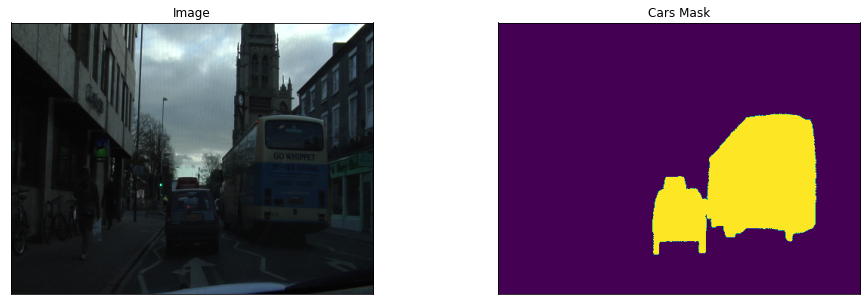

In [7]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [8]:
import albumentations as albu

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

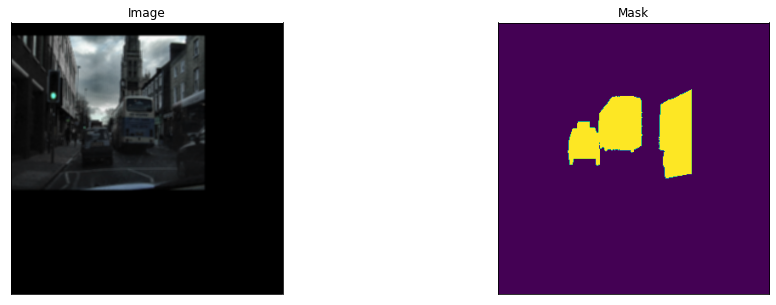

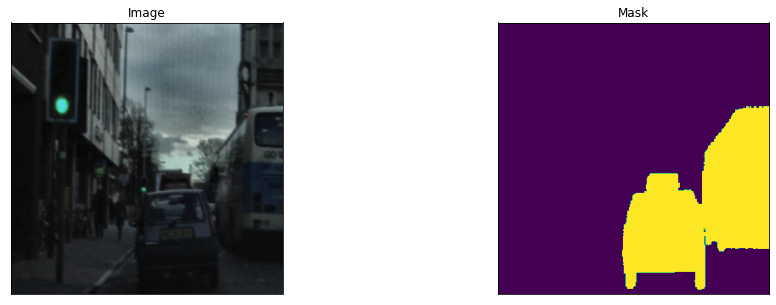

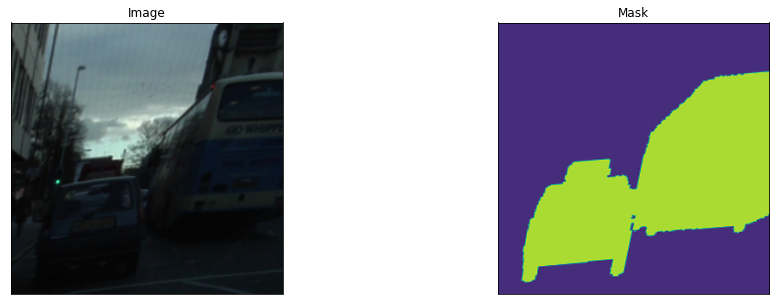

In [10]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [11]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [12]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [14]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [16]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:06<00:00, 15.10it/s, dice_loss - 0.518, iou_score - 0.3989]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:06<00:00, 15.20it/s, dice_loss - 0.3351, iou_score - 0.5769]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:06<00:00, 15.30it/s, dice_loss - 0.3445, iou_score - 0.5625]

Epoch: 3
valid: 100%|██████████| 101/101 [00:06<00:00, 15.14it/s, dice_loss - 0.3056, iou_score - 0.608] 
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:06<00:00, 15.13it/s, dice_loss - 0.2951, iou_score - 0.6149]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:06<00:00, 15.12it/s, dice_loss - 0.2316, iou_score - 0.677] 
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:06<00:00, 15.16it/s, dice_loss - 0.2405, iou_score - 0.6687]

Epoch: 7
valid: 100%|██████████| 101/101 [00:06<00:00, 15.15it/s, dice_loss - 0.3043, iou_score - 0.5991]

Epoch: 8
valid: 100%|██████████| 101/101 [00:06<00:00, 15.03it/s, dice_loss - 0

valid: 100%|██████████| 101/101 [00:06<00:00, 14.48it/s, dice_loss - 0.1596, iou_score - 0.7593]
Model saved!


## Test best saved model

In [23]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [24]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [25]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:19<00:00, 11.99it/s, dice_loss - 0.192, iou_score - 0.7462] 


## Visualize predictions

In [26]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

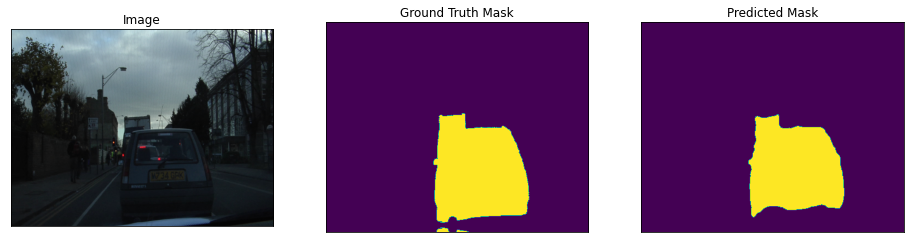

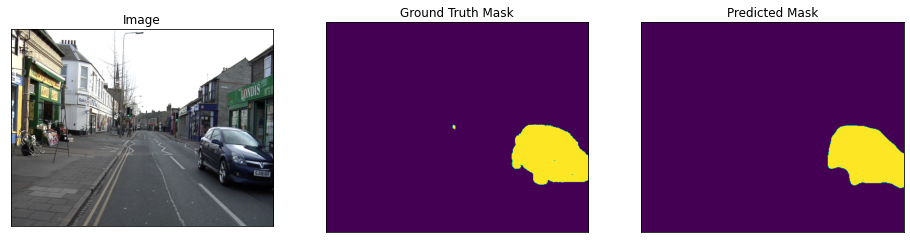

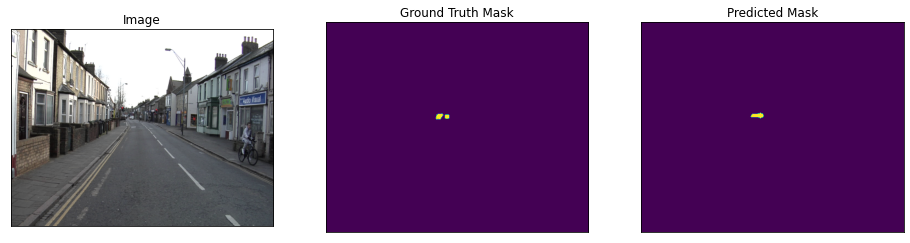

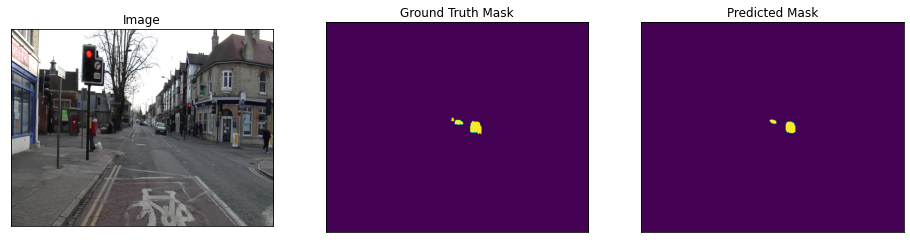

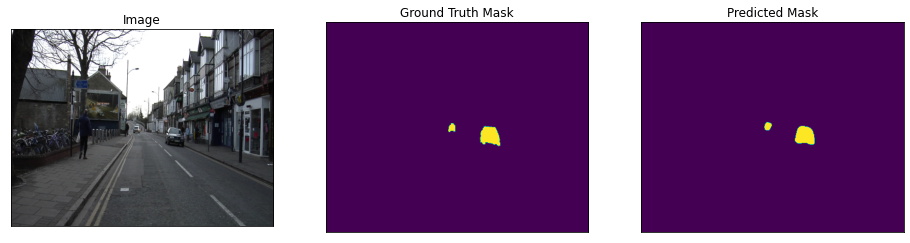

In [27]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [29]:
#export to ""./best_model.onnx"
best_model.eval()

MODEL_DIM = 320
BATCH_SIZE = 1
CHANNELS = 3

dummy_input = torch.randn(BATCH_SIZE, 
                          CHANNELS,
                          MODEL_DIM,
                          MODEL_DIM,
                          device='cuda')

input_names = [ "input/input.1" ] 
output_names = [ "output/output.1" ]

torch.onnx.export(model, 
                  dummy_input,
                  ("./best_model.pth").replace(".pth",".onnx"), 
                  verbose=True, input_names=input_names, 
                  output_names=output_names,
                  opset_version=11,)


graph(%input/input.1 : Float(1, 3, 320, 320),
      %encoder.layer0.conv1.weight : Float(64, 3, 7, 7),
      %encoder.layer0.bn1.weight : Float(64),
      %encoder.layer0.bn1.bias : Float(64),
      %encoder.layer0.bn1.running_mean : Float(64),
      %encoder.layer0.bn1.running_var : Float(64),
      %encoder.layer1.0.conv1.weight : Float(128, 64, 1, 1),
      %encoder.layer1.0.bn1.weight : Float(128),
      %encoder.layer1.0.bn1.bias : Float(128),
      %encoder.layer1.0.bn1.running_mean : Float(128),
      %encoder.layer1.0.bn1.running_var : Float(128),
      %encoder.layer1.0.conv2.weight : Float(128, 4, 3, 3),
      %encoder.layer1.0.bn2.weight : Float(128),
      %encoder.layer1.0.bn2.bias : Float(128),
      %encoder.layer1.0.bn2.running_mean : Float(128),
      %encoder.layer1.0.bn2.running_var : Float(128),
      %encoder.layer1.0.conv3.weight : Float(256, 128, 1, 1),
      %encoder.layer1.0.bn3.weight : Float(256),
      %encoder.layer1.0.bn3.bias : Float(256),
      %encoder.

Image: data/CamVid/test/0001TP_008550.png


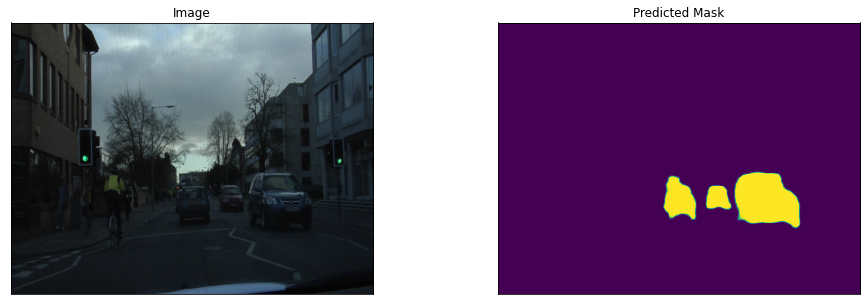

Image: data/CamVid/test/0001TP_008580.png


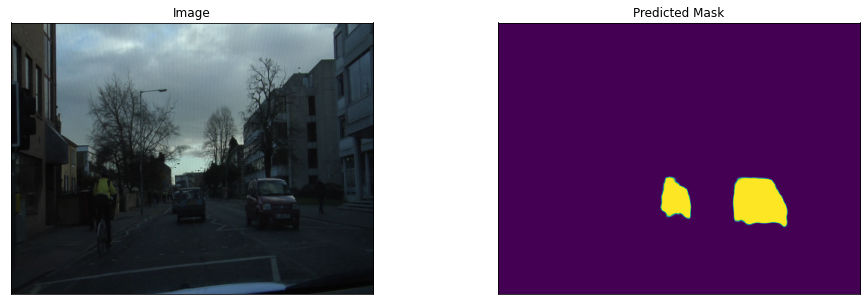

Image: data/CamVid/test/0001TP_008610.png


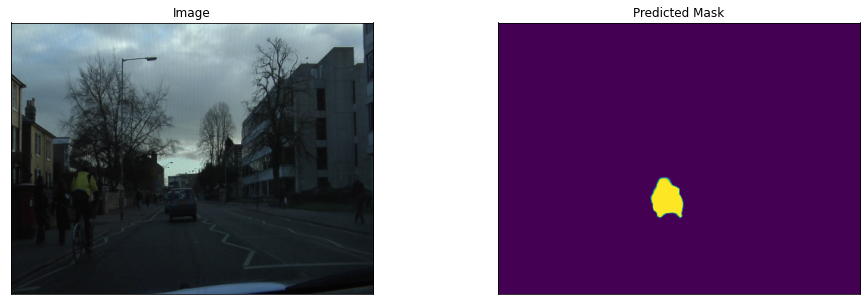

Image: data/CamVid/test/0001TP_008640.png


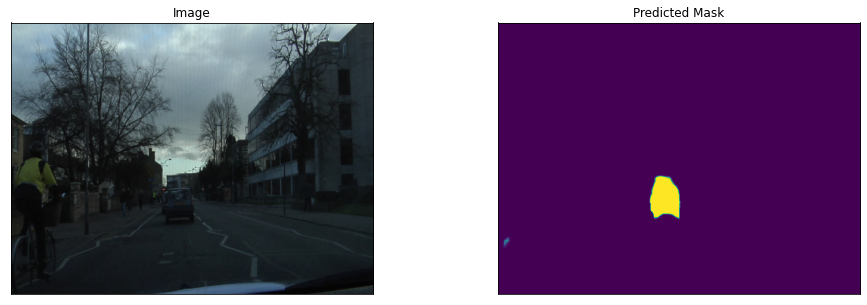

Image: data/CamVid/test/0001TP_008670.png


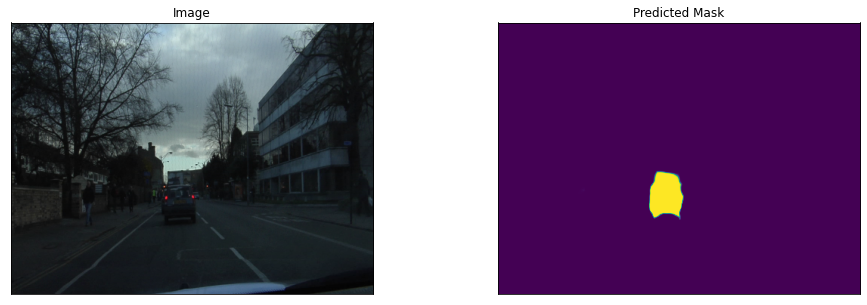

In [38]:
#do inferrence in onnxruntime

import onnxruntime

from PIL import Image

from typing import Tuple
from pathlib import Path

ort_session = onnxruntime.InferenceSession("./best_model.onnx")

from segmentation_models_pytorch.encoders import resnet

mean = resnet.resnet_encoders["resnext50_32x4d"]["pretrained_settings"]["imagenet"]["mean"]
std = resnet.resnet_encoders["resnext50_32x4d"]["pretrained_settings"]["imagenet"]["std"]


def get_box_dimensions_offset(
    cur_column: int,
    cur_row: int,
    tile_size_x: int,
    tile_size_y: int,
    model_size_x: int,
    model_size_y: int,
    gutter_x: int,
    gutter_y: int,
    xres: int,
    yres: int,
) -> Tuple[Tuple[int, int, int, int], int, int, int, int]:
    minx = int(max(0, (cur_column + 1) * tile_size_x - model_size_x + gutter_x))
    miny = int(max(0, (cur_row + 1) * tile_size_y - model_size_y + gutter_y))
    maxx = int(min(xres, (cur_column + 1) * tile_size_x + gutter_x))
    maxy = int(min(yres, (cur_row + 1) * tile_size_y + gutter_y))
    cur_width = maxx - minx
    cur_height = maxy - miny
    offsetx = 0 if minx else gutter_x
    offsety = 0 if miny else gutter_y
    cur_box = (minx, miny, maxx, maxy)
    return cur_box, cur_width, cur_height, offsetx, offsety

def test( X: Path, model_size_x: int, model_size_y: int, tile_size_x: int, tile_size_y: int, mean: Tuple[float,float,float], std: Tuple[float,float,float]) -> Tuple[np.array, np.array]:
    initial_input = Image.open(X)

    xres = initial_input.width
    yres = initial_input.height
    DEVICE = "cuda"
    if not torch.cuda.is_available():
        DEVICE = "cpu"
    big_result = Image.new("F", (xres, yres))

    num_rows = int(xres / tile_size_x + (1 if (xres % tile_size_x) else 0))
    num_columns = int(yres / tile_size_y + (1 if (yres % tile_size_y) else 0))
    gutter_x = int((model_size_x - tile_size_x) / 2)
    gutter_y = int((model_size_y - tile_size_y) / 2)

    for cur_column in range(num_rows):
        for cur_row in range(num_columns):
            (
                cur_box,
                cur_width,
                cur_height,
                offsetx,
                offsety,
            ) = get_box_dimensions_offset(
                cur_column,
                cur_row,
                tile_size_x,
                tile_size_y,
                model_size_x,
                model_size_y,
                gutter_x,
                gutter_y,
                xres,
                yres,
            )

            snip = initial_input.crop(box=cur_box)
            input_buf_small = Image.new("RGB", size=(model_size_x, model_size_y))
            input_buf_small.paste(snip, (offsetx, offsety))
            mean = np.asarray(mean)
            std = np.asarray(std)
            input_x = np.array(input_buf_small).astype(float)
            input_x /= 255.0

            input_x = input_x - mean
            input_x = input_x / std
            
            
            ort_inputs = {ort_session.get_inputs()[0].name: np.expand_dims(input_x.transpose((-1, 0, 1)).astype(np.float32),axis=0)}
            pr_mask = ort_session.run(None, ort_inputs)
            pr_mask_img = Image.fromarray(pr_mask[0].squeeze(), "F")

            result_tile = pr_mask_img.crop(
                box=(gutter_x, gutter_y, gutter_x + cur_width, gutter_y + cur_height)
            )
            big_result.paste(
                result_tile,
                (
                    cur_column * tile_size_x,
                    cur_row * tile_size_y,
                    cur_column * tile_size_x + result_tile.width,
                    cur_row * tile_size_y + result_tile.height,
                ),
            )
    return np.array(initial_input), np.array(big_result)

NUM_PLOTS = 5
    
for i in range(NUM_PLOTS):
    image_file_path = Path(test_dataset.images_fps[i])
    a,c = test(image_file_path,320,320,240,240,mean,std)  
    cv2.imwrite(f"./example_PRY_onnx_.{i}.jpg",c*255.0)
    print(f"Image: {image_file_path}")
    visualize(
        image = a,
        predicted_mask=c
    )